# About

We need a good order parameter to distinguish stability.
This notebook is for developing this OP, which is essentially a measure of how far apart the protomer falls.

In [1]:
import signac
import numpy as np
from glotzformats import reader
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import tqdm
import gsd
from gsd import fl
from gsd import hoomd as gsdhoomd
from freud.box import Box
import itertools

%matplotlib notebook

### My analysis
The centroid_msd function computes the distance of the particles from their centroid at each step.
This is my preferred form of analysis.
**Note: I am logging the value directly in HOOMD now, but I may still need to recalculate it on the fly.**

In [2]:
def centroid_MSD(positions, box):
    """Compute the MSD of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    avg_distances = np.mean(distances, axis = -1)
    return avg_distances

In [3]:
def centroid_Rg(positions, box):
    """Compute the radius of gyration of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    
    # Only difference with simple distance calc is that instead of averaging here, we take the norm
    rgs = np.linalg.norm(distances, axis = -1)/np.sqrt(distances.shape[1])
    return rgs

In [4]:
r = reader.PosFileReader()

with open('figure_files/denatured_protomer.pos') as f:
    traj = r.read(f)
    traj.load_arrays()
    print("The Rg for the denatured protomer is {}".format(centroid_Rg(traj.positions, traj[-1].box)[-1]))
    
with open('figure_files/intact_protomer.pos') as f:
    traj = r.read(f)
    traj.load_arrays()
    print("The Rg for the intact protomer is {}".format(centroid_Rg(traj.positions, traj[-1].box)[-1]))
    

The Rg for the denatured protomer is 26.227733612060547
The Rg for the intact protomer is 6.328243255615234


### Jens's analysis

Jens's MSD based analysis.

In [5]:
def autocorrFFT_n(x):
    N = len(x)
    F = np.fft.fft(x, n=2*N, axis=0)  # 2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD, axis=0)
    res = (res[:N]).real  # now we have the autocorrelation in convention B
    n = N*np.ones(N)-np.arange(0, N)  # divide res(m) by (N-m)
    return res/n[:, None]  # this is the autocorrelation in convention A


def msd_fft_n(r):
    if r.ndim == 2:
        r = np.asarray(r).reshape((-1, 1, 3))
    N = len(r)
    D = np.square(r).sum(axis=2)
    D = np.append(D, np.zeros(r.shape[:2]), axis=0)
    S2 = np.sum([autocorrFFT_n(r[:, :, i]) for i in range(r.shape[2])], axis=0)
    Q = 2*D.sum(axis=0)
    S1 = np.zeros(r.shape[:2])
    for m in range(N):
        Q = Q-D[m-1, :]-D[N-m, :]
        S1[m] = Q/(N-m)
    return np.mean(S1-2*S2, axis=1)

### Unit conversion

While my data space is in terms of kappa, ideally we would want the data space to be in terms of the concentrations.
This function performs the conversion for plotting purposes.

In [6]:
def kappa_to_conc(kappa, eps=None, T=None):
    """Converts kappa (the inverse screening length) into a concentration in millimolar units"""
    e = 1.60217646e-19
    a = 8.864187817e-12
    k = 1.3806485279e-23
    Na = 6.0221415e23
    T_def = 300
    epsr_def = 78 #Note that this term is temperature dependent
    if eps is None:
        eps = epsr_def
    if T is None:
        T = T_def
    return 1000*(a*eps*k*T)/(((kappa * 10**(9))**(-2)) * (e**2) * Na * 2000)
kappa_to_conc(0.73)

49.360780329933135

### Statistical averaging technique

In [7]:
#Implements the method of H. Flyvbjerg and H. G. Petersen
#  doi: 10.1063/1.457480

import math
class BlockAverage:
    def __init__(self, ydata, minlen=16):
        block = np.array(ydata)
        self.err_est = []
        self.err_err = []
        self.n = []
        self.num_samples = []
        i = 0
        while (len(block) >= int(minlen)):
            e = 1.0/(len(block)-1)*np.var(block)
            self.err_est.append(math.sqrt(e))
            self.err_err.append(math.sqrt(e/2.0/(len(block)-1)))
            self.n.append(i)
            self.num_samples.append(len(block))
            block_l = block[1:]
            block_r = block[:-1]
            block = 1.0/2.0*(block_l + block_r)
            block = block[::2]
            i += 1

        # convert to np arrays
        self.err_est = np.array(self.err_est)
        self.err_err = np.array(self.err_err)
        self.num_samples = np.array(self.num_samples)

    def get_hierarchical_errors(self):
        return (self.n, self.num_samples, self.err_est, self.err_err)

    def get_error_estimate(self,relsigma=1.0):
        i = self.n[-1]
        while True:
            # weighted error average
            avg_err = np.sum(self.err_est[i:]/self.err_err[i:]/self.err_err[i:])
            avg_err /= np.sum(1.0/self.err_err[i:]/self.err_err[i:])

            sigma = self.err_err[i]
            cur_err = self.err_est[i]
            delta = abs(cur_err - avg_err)
            if (delta > relsigma*sigma or i == 0):
                i += 1
                break
            i -= 1

        # compute average error in plateau region
        avg_err = np.sum(self.err_est[i:]/self.err_err[i:]/self.err_err[i:])
        avg_err /= np.sum(1.0/self.err_err[i:]/self.err_err[i:])
        return (i,avg_err)

### Standardized plot

In [1]:
#mpl.rcParams.update(mpl.rcParamsDefault) # To reset to defaults
#plt.rcParams['errorbar.capsize'] = 5.0
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif', serif='Times')

from matplotlib import font_manager

class pretty_error_plot(object):
    def __init__(self, fig=None, ax=None, fs=None, xlabel=None, ylabel=None, title=None,
                 cmap=None, error_fill=False, use_legend=True, ypad=0.05, xpad=0.05, facets=(),
                 rescale_plot=True):
        if fig is None and ax is None:
            if facets:
                if fs is None:
                    fs = (8, 6)
                fig, ax = plt.subplots(*facets, figsize=fs)
                plt.subplots_adjust(hspace=0.3, wspace=0.3)
            else:
                fig, ax = plt.subplots(1, 1)
        self.fig = fig
        self.ax = ax

        # Standardize some plotting standards
        if rescale_plot:
            # Whether or not to enforce 4/3 plot
            dims = fig.get_size_inches()
            if np.abs(dims[0]/dims[1] - 4/3) > 0.1:
                fig.set_size_inches(dims[1]*4/3, dims[1])
        if facets:
            for a in ax.flatten():
                a.spines["top"].set_visible(False)  
                a.spines["right"].set_visible(False)  
        else:
            ax.spines["top"].set_visible(False)  
            ax.spines["right"].set_visible(False)  

        # Labeling
        ticks_font = font_manager.FontProperties(
            family='Arial', style='normal', weight='normal', stretch='normal', size=16)
        if facets:
            for a in ax.flatten():
                a.tick_params(axis='both', which='major', labelsize=16)
                a.tick_params(axis='both', which='minor', labelsize=16)
                for label in a.get_xticklabels():
                    label.set_fontproperties(ticks_font)
                for label in a.get_yticklabels():
                    label.set_fontproperties(ticks_font)
        else:
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            for label in ax.get_xticklabels():
                label.set_fontproperties(ticks_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(ticks_font)

        if title:
            self.title = title
            if facets:
                fig.suptitle(title, fontsize=24)
            else:
                ax.set_title(title, fontsize=24)  
        if xlabel:
            self.xlabel = xlabel
            if facets:
                # Only label the edges
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if i == facets[0]-1:
                            a.set_xlabel(xlabel, fontsize=20)  
            else:
                ax.set_xlabel(xlabel, fontsize=20)  
        if ylabel:
            self.ylabel = ylabel
            if facets:
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if j == 0:
                            a.set_ylabel(ylabel, fontsize=20)  
            else:
                ax.set_ylabel(ylabel, fontsize=20)  
        
        self.num_plots = 0
        if cmap:
            self.cmap = plt.get_cmap(cmap)
        else:
            self.cmap = None
        self.use_legend = use_legend
        self.xpad = xpad
        self.ypad = ypad
        self.error_fill = error_fill
        self.lines = [] 
        self.ebarcaps = []
        self.ebars = []
        self.xdata = [] 
        self.ydata = [] 
        if facets:
            self.tot_plots = facets[0]*facets[1]
        else:
            self.tot_plots = 1
        self.facets = facets
        
        # Establish sensible limits
        self.xmin = np.inf
        self.xmax = -np.inf
        self.ymin = np.inf
        self.ymax = -np.inf
        
            
    def add_plot(self, x, y, yerr=None, plot_title=None, *args, **kwargs):
        if self.facets:
            if self.facets[0] == 1 or self.facets[1] == 1:
                # If it's a 1d array
                ax = self.ax[self.num_plots]
            else:
                xpos = self.num_plots // self.facets[1]
                ypos = self.num_plots % self.facets[1]
                ax = self.ax[xpos, ypos]
        else:
            ax = self.ax
        if yerr is not None:
            if self.error_fill:
                lines = ax.plot(x, y, *args, **kwargs)
                self.lines.append(lines[0])
                self.ebars.append(ax.fill_between(x, y-yerr, y+yerr))
            else:
                [plotline, caplines, barlinecols] = ax.errorbar(x, y, yerr, *args, **kwargs)
                self.lines.append(plotline)
                self.ebarcaps.append(caplines)
                self.ebars.append(barlinecols)
        else:
            lines = ax.plot(x, y, *args, **kwargs)
            self.lines.append(lines[0])
        
        if plot_title is not None:
            ax.set_title(plot_title, fontsize=20)
        
        # Update limits
        curxmin = np.min(x)
        curxmax = np.max(x)
        if curxmin < self.xmin:
            self.xmin = curxmin
        if curxmax > self.xmax:
            self.xmax = curxmax
            
        if yerr is not None:
            curymin = np.min(y-yerr)
            curymax = np.max(y+yerr)
        else:
            curymin = np.min(y)
            curymax = np.max(y)
            
        if curymin < self.ymin:
            self.ymin = curymin
        if curymax > self.ymax:
            self.ymax = curymax
            
        self.num_plots += 1
        
    def disp(self, scale=True):
        # Figure out how many colors are needed, then set
        if self.cmap is not None:
            color_nums = np.linspace(0, 0.9, self.num_plots)
            colors = [self.cmap(c) for c in color_nums]
        
            for i, plotline in enumerate(self.lines):
                plotline.set_color(colors[i])
                if len(self.ebars):
                    if self.error_fill:
                        self.ebars[i].set_color(colors[i])
                    else:
                        for eb in self.ebars[i]:
                            eb.set_color(colors[i])
                        for ebc in self.ebarcaps[i]:
                            ebc.set_color(colors[i])
            
        # Fix limits
        if scale:
            xpad = (self.xmax-self.xmin)*self.xpad
            self.xmax += xpad
            self.xmin -= xpad

            ypad = (self.ymax-self.ymin)*self.ypad
            self.ymax += ypad
            self.ymin -= ypad
            
            if self.facets:
                for a in self.ax.flatten():
                    a.set_xlim(left=self.xmin, right=self.xmax)
                    a.set_ylim(bottom=self.ymin, top=self.ymax)
            else:
                self.ax.set_xlim(left=self.xmin, right=self.xmax)
                self.ax.set_ylim(bottom=self.ymin, top=self.ymax)
            
        if self.use_legend:
            if self.facets:
                if len(self.ebars):
                    for a in self.ax.flatten():
                        handles, labels = a.get_legend_handles_labels()
                        handles = [h[0] for h in handles]
                        a.legend(handles, labels, loc='best', fontsize=20)
                else:
                    for a in self.ax.flatten():
                        a.legend(loc='best', fontsize=20)
            else:
                if len(self.ebars):
                    handles, labels = self.ax.get_legend_handles_labels()
                    handles = [h[0] for h in handles]
                    self.ax.legend(handles, labels, loc='best', fontsize=20)
                else:
                    self.ax.legend(loc='best', fontsize=20)
            
        # Show
        #self.fig.canvas.draw()

### Accumulate Data

In [9]:
config = signac.common.config.get_config('../signac.rc')
config.update(dict(workspace_dir='workspace'))
config.write()
project = signac.get_project()

In [10]:
project = signac.get_project()
r = reader.GSDHoomdFileReader()
fn = 'evaluate.gsd'
data_fn = 'evaluate_centroid.log'

jobs = []
pos_seg_opts = []
seg_inds = []
kappas = []
run_nums = []
mutations = []
mutated_chains = []
pos_types = []
distances = []
rgs = []
initial_rgs = []
msds = []
num_frames = []
pdb_files = []

# Whether to use the dump file or recalculate distances on the fly 
recalc_distance = True
for job in tqdm.tqdm_notebook(
    project.find_jobs(
        {"$and":
             [
                 {"pdb_file": {"$in": 
                      ['protomer_1_alternating_head_tail.pdb',
                       'protomer_1_all_tail_tail.pdb',
                       'protomer_1_all_head_tail.pdb',
                       'protomer_1_all_head_head.pdb']}},
                 {"shift": {"$exists": False}}
             ]
        })):
    if job.isfile(data_fn):
        with job:
            if recalc_distance:
                with open(job.fn(fn), 'rb') as f:
                    try:
                        traj = r.read(f)
                        traj.load_arrays()

                        # Find the first frame after compression
                        first_step = 1 + job.doc.num_expansions_evaluate + job.doc.evaluate_num_steps_compressed
                        gsd_traj = gsd.hoomd.open(job.fn('evaluate.gsd'))
                        initial_rgs.append(centroid_Rg(traj.positions[:1], traj[0].box)[0])
                        for i, frame in enumerate(gsd_traj):
                            if frame.configuration.step > first_step:
                                break
                        distances.append(centroid_MSD(traj.positions[i:], traj[i].box))
                        rgs.append(centroid_Rg(traj.positions[i:], traj[i].box))
                    except Exception as e:
                        # Some of the GSDs are corrupted for some reason
                        print("Allowing exception {} through".format(e))
                        continue
            else:
                try:
                    tmp = np.genfromtxt(data_fn, invalid_raise=False)[:, -1]
                    distances.append(tmp)
                except:
                    print("Failed for job {}".format(job))
                    continue
                
        # Can't store the segments directly since they're a list
        # (pandas allows, but grouping fails), so instead store
        # an id with a lookup table
        if job.sp.positive_segments not in pos_seg_opts:
            ind = len(pos_seg_opts)
            pos_seg_opts.append(job.sp.positive_segments)
        else:
            ind = pos_seg_opts.index(job.sp.positive_segments)
        jobs.append(job)
        seg_inds.append(ind)
        kappas.append(job.sp.kappa)
        mutation = job.sp.get('mutation')
        mutations.append(', '.join(mutation) if mutation is not None else 'None')
        mutated_chains.append(job.sp.get('mutated_chain', 'None'))
        run_nums.append(job.sp.run_num)
        pdb_files.append(job.sp.pdb_file)
        
        # For Jens's analysis
#        with job:
#            traj = gsdhoomd.HOOMDTrajectory(fl.GSDFile(fn, 'rb'))
#            box = traj[-1].configuration.box
#            npart = len(traj[-1].particles.position)
#            fbox = Box(Lx=box[0], Ly=box[1], Lz=box[2],
#                       xy=box[3], xz=box[4], yz=box[5])
#            positions_unwrap = []
#            for f in traj:
#                pos_unwrap = np.copy(f.particles.position)
#                fbox.unwrap(pos_unwrap, f.particles.image)
#
#                delta_unwrap = []
#                for p in itertools.combinations(range(npart), 2):
#                    delta = pos_unwrap[p[0]] - pos_unwrap[p[1]]
#                    delta_unwrap.append(delta)
#                positions_unwrap.append(delta_unwrap)
#            msd = msd_fft_n(np.array(positions_unwrap))
#        msds.append(msd)
#        num_frames.append(len(traj))

In [11]:
# Don't require storing distances since they may not all be necessary
interval = 100 # The number of samples used in the actual run for termination
initial_rg = np.mean(initial_rgs)
df_data_all = pd.DataFrame(dict(
    job = jobs,
    jobid = [j.get_id() for j in jobs],
    positive_segments = seg_inds,
    kappa = kappas,
    distance = distances,
    rg = rgs,
    run_num = run_nums,
    final_distance = [x[-1] for x in distances],
    avg_distance = [np.mean(x) for x in distances],
    final_rg = [x[-1] for x in rgs],
    avg_rg = [np.mean(x) for x in rgs],
    mutation = mutations,
    mutated_chain = mutated_chains,
    pdb_file = pdb_files,
))

jobs_exclude = []
df_data_final = df_data_all.loc[~df_data_all['jobid'].isin(jobs_exclude)].copy()
df_data_final = df_data_final[~((df_data_final['run_num'] > 4) & 
                (df_data_final['pdb_file'] == 'protomer_1_alternating_head_tail.pdb')) &
                             ~((df_data_final['pdb_file'] == 'protomer_1_alternating_head_tail.pdb') &
                              (df_data_final['run_num'] > 3) &
                              (df_data_final['kappa'] > 0.69))]
df_data_final.drop(['distance', 'rg'], axis = 1, inplace = True)
grouped = df_data_final[
    (df_data_final['mutation'] == 'None') &
    (df_data_final['kappa'] > 0.54) &
    (df_data_final['kappa'] <= 0.74) &
    (df_data_final['run_num'] <= 5) &
    (df_data_final['mutation'] == 'None')
#].groupby(['positive_segments', 'mutation', 'kappa'])
].groupby(['pdb_file', 'mutation', 'kappa'])
def std_mean(x):
    """Helper function to compute the average standard deviation by averaging variances"""
    return np.sqrt(np.sum(np.square(x)))
df_data = grouped.agg(dict(
    final_distance=['std', 'mean'],
    avg_distance=['mean', 'std'],
    final_rg=['std', 'mean'],
    avg_rg=['mean', 'std'],
    )).reset_index()
df_data.columns = [' '.join(col).strip().replace(' ', '_') for col in df_data.columns.values]

## Plot for new structures Anna requested

In [69]:
experimental_rg = 6.5
stability_limit = 2*experimental_rg

#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

p = pretty_error_plot(#xlabel="Concentration (mM)", ylabel="Distance (nm)", #title="Average distance from centroid",
                      facets=(1, 4), fs=(18, 4), use_legend=False, rescale_plot=False)
# Only get the ones that we want, and this way they're in a predictable order
pdb_fns = ['protomer_1_alternating_head_tail.pdb',
           'protomer_1_all_tail_tail.pdb',
           'protomer_1_all_head_tail.pdb',
           'protomer_1_all_head_head.pdb']
for fn in pdb_fns:
    data_plot  = df_data.loc[(df_data['mutation'] == 'None') &
                             (df_data['pdb_file'] == fn)]
    data_plot.sort_values(by='kappa')
    p.add_plot(x=kappa_to_conc(data_plot['kappa']), y=np.array(data_plot['avg_rg_mean']), yerr=data_plot['avg_rg_std'],
               linestyle='None', marker='^', markersize=8, color='#2B8B27', capsize=6)#,
               #plot_title=fn.replace('.pdb', '').replace('protomer_1_', '').replace('_', '\\_'))
p.disp(True)
for i, ax in enumerate(p.ax.flatten()):
    ax.set_ylim([0, 30])
    ax.set_xlim([30, 55])
    if i == 0:
        ax.axhline(y = experimental_rg, xmin=0, xmax=1, linestyle='--', label='intact', c="#BE1E27")
        ax.axhline(y = stability_limit, xmin=0, xmax=1, linestyle='--', label='denatured', c="#BE1E27")
    else:
        ax.axhline(y = experimental_rg, xmin=0, xmax=1, linestyle='--', c="#BE1E27")
        ax.axhline(y = stability_limit, xmin=0, xmax=1, linestyle='--', c="#BE1E27")
#p.fig.legend()
p.fig.savefig("images/Average_faceted_new.eps", format='eps')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Figure with control data

In [15]:
config = signac.common.config.get_config('../signac.rc')
config.update(dict(workspace_dir='workspace_control'))
config.write()
project = signac.get_project()

In [16]:
project = signac.get_project()
r = reader.GSDHoomdFileReader()
fn = 'evaluate.gsd'
data_fn = 'evaluate_centroid.log'

jobs = []
pos_seg_opts = []
seg_inds = []
kappas = []
run_nums = []
pos_types = []
distances = []
rgs = []
initial_rgs = []
num_frames = []

# Whether to use the dump file or recalculate distances on the fly 
recalc_distance = True
for job in tqdm.tqdm_notebook(project):
    if job.isfile(data_fn):
        with job:
            if recalc_distance:
                with open(job.fn(fn), 'rb') as f:
                    try:
                        traj = r.read(f)
                        traj.load_arrays()

                        # Find the first frame after compression
                        first_step = 1 + job.doc.num_expansions_evaluate + job.doc.evaluate_num_steps_compressed
                        gsd_traj = gsd.hoomd.open(job.fn('evaluate.gsd'))
                        initial_rgs.append(centroid_Rg(traj.positions[:1], traj[0].box)[0])
                        for i, frame in enumerate(gsd_traj):
                            if frame.configuration.step > first_step:
                                break
                        distances.append(centroid_MSD(traj.positions[i:], traj[i].box))
                        rgs.append(centroid_Rg(traj.positions[i:], traj[i].box))
                    except Exception as e:
                        # Some of the GSDs are corrupted for some reason
                        print("Allowing exception {} through".format(e))
                        continue
            else:
                try:
                    tmp = np.genfromtxt(data_fn, invalid_raise=False)[:, -1]
                    distances.append(tmp)
                except:
                    print("Failed for job {}".format(job))
                    continue
                
        # Can't store the segments directly since they're a list
        # (pandas allows, but grouping fails), so instead store
        # an id with a lookup table
        if job.sp.positive_segments not in pos_seg_opts:
            ind = len(pos_seg_opts)
            pos_seg_opts.append(job.sp.positive_segments)
        else:
            ind = pos_seg_opts.index(job.sp.positive_segments)
        jobs.append(job)
        seg_inds.append(ind)
        kappas.append(job.sp.kappa)
        run_nums.append(job.sp.run_num)

In [22]:
pos_seg_opts.index([106, 102, 93, 109, 87, 108, 110, 103])

1

In [23]:
# Don't require storing distances since they may not all be necessary
df_data_all = pd.DataFrame(dict(
    job = jobs,
    jobid = [j.get_id() for j in jobs],
    positive_segments = seg_inds,
    kappa = kappas,
    distance = distances,
    run_num = run_nums,
    avg_rg = [np.mean(x) for x in rgs],
))

# Don't include the statepoints with positive and negative rings, that's a separate plot
grouped = df_data_all[
    df_data_all['positive_segments'] !=  pos_seg_opts.index([106, 102, 93, 109, 87, 108, 110, 103])].groupby(
    ['positive_segments', 'kappa'])
df_data = grouped.agg(dict(
    avg_rg=['mean'],
    )).reset_index()
df_data.columns = [' '.join(col).strip().replace(' ', '_') for col in df_data.columns.values]

# Add a sign column for explicit usage
opts = np.array(pos_seg_opts)[np.array(df_data['positive_segments'])]
negs = [opt == [] for opt in opts]
df_data['sign'] = ['Negative' if o else 'Positive' for o in negs ]

<IPython.core.display.Javascript object>


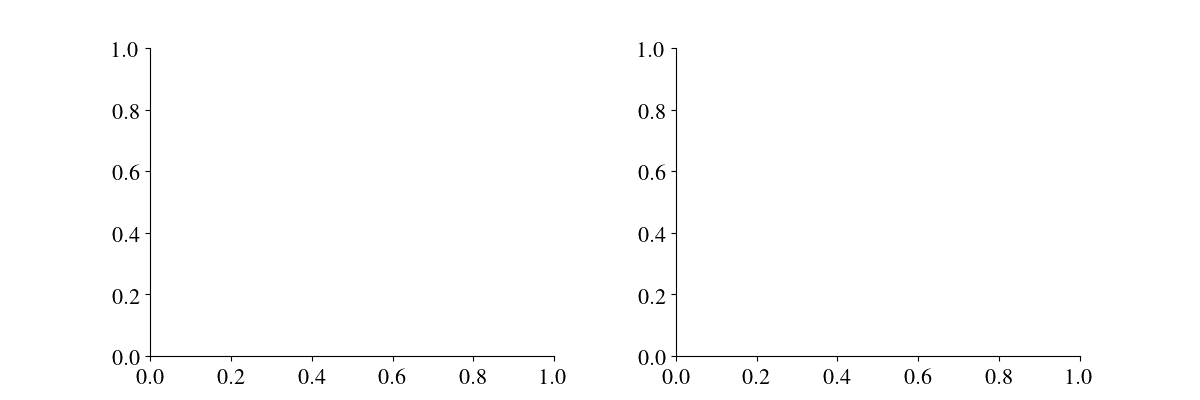

KeyError: 'sign'

In [26]:
p = pretty_error_plot(facets=(1, 2), fs=(12, 4), use_legend=False, rescale_plot=False)
signs = ['Positive', 'Negative']
for sg in signs:
    data_plot = df_data.loc[(df_data['sign'] == sg)]
    data_plot.sort_values(by='kappa')
    p.add_plot(x=kappa_to_conc(data_plot['kappa']), y=np.array(data_plot['avg_rg_mean']),
               linestyle='None', marker='o', color='k')
p.disp(True)
for i, ax in enumerate(p.ax.flatten()):
    ax.set_ylim([0, 35])
    ax.set_xlim([30, 55])
    if i == 0:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', label='intact', c=(0/255, 146/255, 146/255))
        ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', label='denatured', c=(146/255, 0/255, 0/255))
    else:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', c=(0/255, 109/255, 219/255))
        ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', c=(146/255, 0/255, 0/255))
#p.fig.legend()
#p.fig.savefig("images/Control_Data.eps", format='eps')

In [30]:
df_data_all[
    df_data_all['positive_segments'] ==  pos_seg_opts.index([106, 102, 93, 109, 87, 108, 110, 103])]

avg_rg                                           distance  \
1  29.700338  [27.183052, 32.699017, 29.073301, 25.624542, 2...   
4  29.150661  [32.0544, 23.057903, 33.470245, 25.913006, 26....   
6  28.244022  [31.25605, 24.462414, 24.97136, 25.79123, 30.8...   

                                job                             jobid  kappa  \
1  e492c9568a6aa1edbd36d9a33dfc56e7  e492c9568a6aa1edbd36d9a33dfc56e7   0.68   
4  9624437e78468d1af1b995179651e5d3  9624437e78468d1af1b995179651e5d3   0.60   
6  7f0138a9296b457b38cc90bf86057232  7f0138a9296b457b38cc90bf86057232   0.74   

   positive_segments  run_num  
1                  1        1  
4                  1        1  
6                  1        1

In [31]:
# Don't include the statepoints with positive and negative rings, that's a separate plot
grouped = df_data_all[
    df_data_all['positive_segments'] ==  pos_seg_opts.index([106, 102, 93, 109, 87, 108, 110, 103])].groupby(
    ['positive_segments', 'kappa'])
df_data = grouped.agg(dict(
    avg_rg=['mean'],
    )).reset_index()
df_data.columns = [' '.join(col).strip().replace(' ', '_') for col in df_data.columns.values]

In [39]:
p = pretty_error_plot(use_legend=False, rescale_plot=False)
data_plot = df_data.copy()
p.add_plot(x=kappa_to_conc(data_plot['kappa']), y=np.array(data_plot['avg_rg_mean']),
           linestyle='None', marker='o', color='k')
p.disp(True)
p.ax.set_ylim([0, 35])
p.ax.set_xlim([30, 55])
p.ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', label='intact', c=(0/255, 146/255, 146/255))
p.ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', label='denatured', c=(146/255, 0/255, 0/255))
#p.fig.legend()
p.fig.savefig("images/Opposite_Rings.eps", format='eps')

<IPython.core.display.Javascript object>

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Trying Shannon's version of the figure

In [61]:
df_percolation_all = df_data_all[df_data_all['pdb_file'].isin(pdb_fns)].copy()
df_percolation_all['denatured'] = (df_percolation_all['avg_rg'] > experimental_rg).astype(int)
grouped = df_percolation_all.groupby(['pdb_file', 'kappa'])
df_percolation = grouped.agg(np.mean).reset_index()

<IPython.core.display.Javascript object>


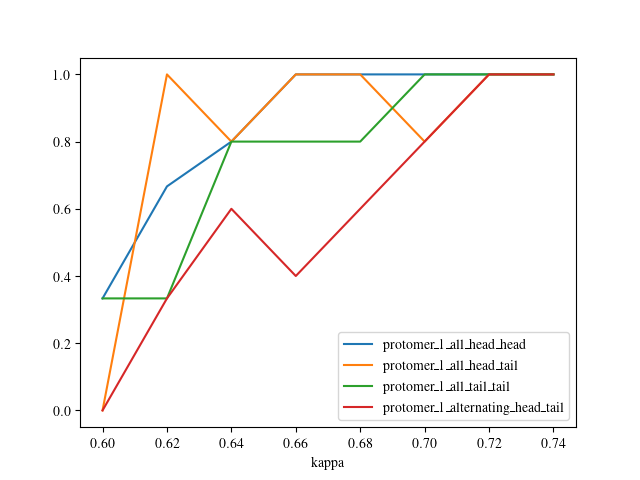

In [62]:
fig, ax = plt.subplots(1, 1)
for name, group in df_percolation.groupby('pdb_file'):
    group.plot.line(x='kappa', y='denatured', ax=ax, label=name.replace('.pdb', '').replace('_', '\\_'))
plt.show()

## Additional versions of the summary figure plot

<IPython.core.display.Javascript object>


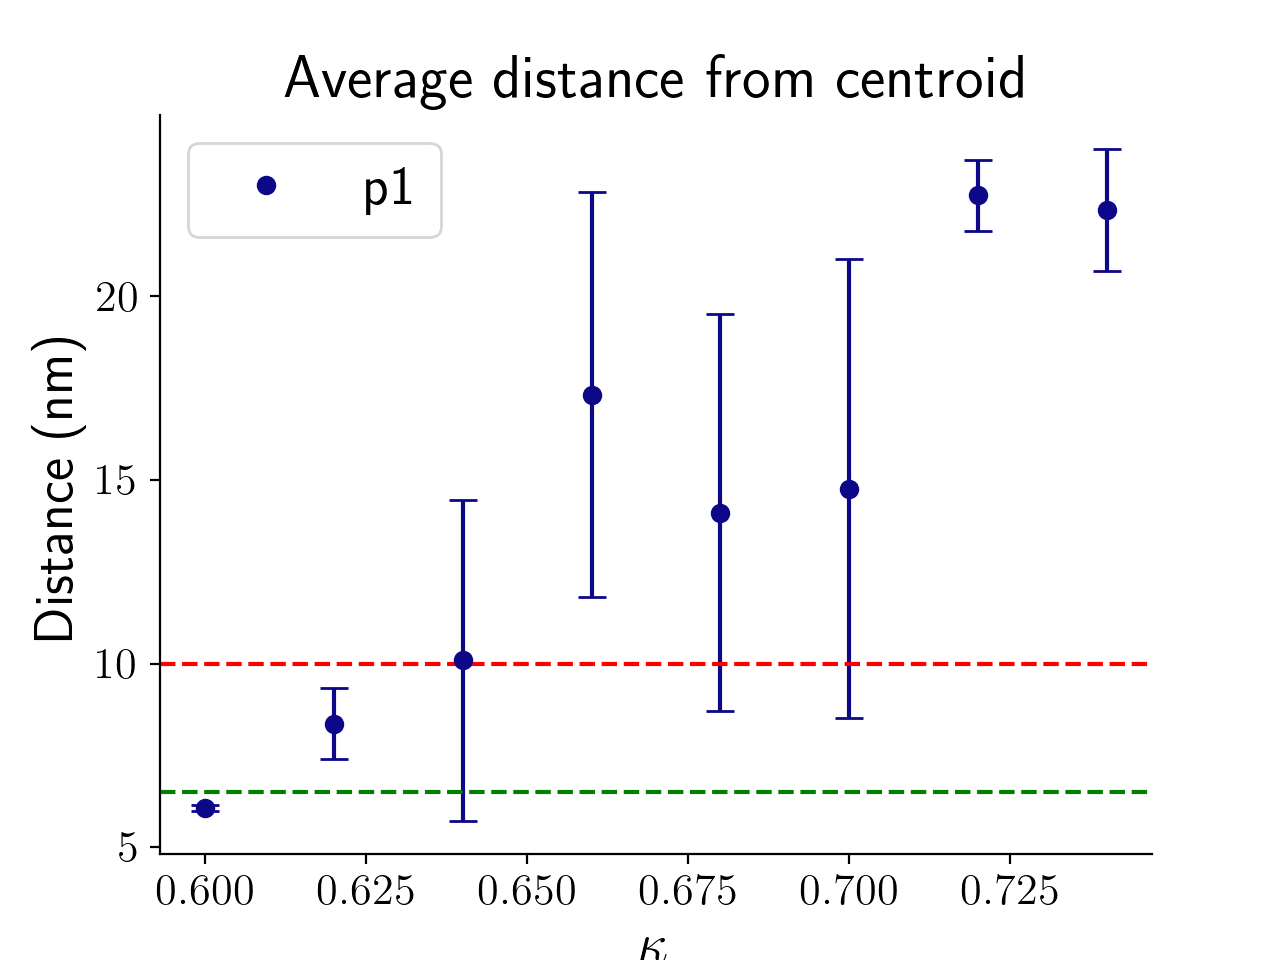

In [14]:
p1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
#p2_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_2_id)]
#p2_plot.sort_values(by='kappa')
#p3_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_3_id)]
#p3_plot.sort_values(by='kappa')
#p4_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_4_id)]
#p4_plot.sort_values(by='kappa')

#fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(xlabel="$\kappa$", ylabel="Distance (nm)", title="Average distance from centroid",
                      fs=(12, 9), cmap="plasma")
p.add_plot(x=p1_plot['kappa'], y=p1_plot['avg_distance_mean'], yerr=p1_plot['avg_distance_std'],
           linestyle='None', marker='o', label='p1')
#p.add_plot(x=p2_plot['kappa'], y=p2_plot['avg_distance_mean'], yerr=p2_plot['avg_distance_std'],
#           linestyle='None', marker='o', label='p2')
#p.add_plot(x=p3_plot['kappa'], y=p3_plot['avg_distance_mean'], yerr=p3_plot['avg_distance_std'],
#           linestyle='None', marker='o', label='p3')
#p.add_plot(x=p4_plot['kappa'], y=p4_plot['avg_distance_mean'], yerr=p4_plot['avg_distance_std'],
#           linestyle='None', marker='o', label='p4')
p.disp(True)
#for ax in p.ax.flatten():
#    ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle='--', label='intact', c='green')
#    ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', label='denatured', c='red')
p.ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle='--', label='intact', c='green')
p.ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', label='denatured', c='red')
p.fig.savefig("images/Average_faceted")

In [35]:
p1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
p2_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_2_id)]
p2_plot.sort_values(by='kappa')
p3_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_3_id)]
p3_plot.sort_values(by='kappa')
p4_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_4_id)]
p4_plot.sort_values(by='kappa')

#fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(xlabel="Concentration (mM)", ylabel="Distance (nm)", title=r"Average distance from centroid",
                      facets=(2, 2), fs=(12, 9), use_legend=False)
p.add_plot(x=kappa_to_conc(p1_plot['kappa']), y=np.array(p1_plot['avg_distance_mean']), yerr=p1_plot['avg_distance_std'],
           linestyle='None', marker='o', plot_title=r'\underline{Protomer 1}', color = 'k')
p.add_plot(x=kappa_to_conc(p2_plot['kappa']), y=np.array(p2_plot['avg_distance_mean']), yerr=p2_plot['avg_distance_std'],
           linestyle='None', marker='o', plot_title=r'\underline{Protomer 2}', color = 'k')
p.add_plot(x=kappa_to_conc(p3_plot['kappa']), y=np.array(p3_plot['avg_distance_mean']), yerr=p3_plot['avg_distance_std'],
           linestyle='None', marker='o', plot_title=r'\underline{Protomer 3}', color = 'k')
p.add_plot(x=kappa_to_conc(p4_plot['kappa']), y=np.array(p4_plot['avg_distance_mean']), yerr=p4_plot['avg_distance_std'],
           linestyle='None', marker='o', plot_title=r'\underline{Protomer 4}', color = 'k')
p.disp(True)
for i, ax in enumerate(p.ax.flatten()):
    if i == 0:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', label='intact', c=(0/255, 146/255, 146/255))
        ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', label='denatured', c=(146/255, 0/255, 0/255))
    else:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', c=(0/255, 109/255, 219/255))
        ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', c=(146/255, 0/255, 0/255))
p.fig.legend(fontsize=16)
p.fig.savefig("images/Average_faceted.eps", format='eps')

<IPython.core.display.Javascript object>

In [434]:
p1_plot = df_data_all.loc[(df_data_all['mutation'] == 'None') & (df_data_all['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
p2_plot = df_data_all.loc[(df_data_all['mutation'] == 'None') & (df_data_all['positive_segments'] == proposed_protomer_2_id)]
p2_plot.sort_values(by='kappa')
p3_plot = df_data_all.loc[(df_data_all['mutation'] == 'None') & (df_data_all['positive_segments'] == proposed_protomer_3_id)]
p3_plot.sort_values(by='kappa')
p4_plot = df_data_all.loc[(df_data_all['mutation'] == 'None') & (df_data_all['positive_segments'] == proposed_protomer_4_id)]
p4_plot.sort_values(by='kappa')

#fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(xlabel="$\kappa$", ylabel="Distance (nm)", title="Average distance from centroid",
                      facets=(2, 2), fs=(12, 9))
p.add_plot(x=p1_plot['kappa'], y=p1_plot['avg_distance'],
           linestyle='None', marker='o', label='p1')
p.add_plot(x=p2_plot['kappa'], y=p2_plot['avg_distance'],
           linestyle='None', marker='o', label='p2')
p.add_plot(x=p3_plot['kappa'], y=p3_plot['avg_distance'],
           linestyle='None', marker='o', label='p3')
p.add_plot(x=p4_plot['kappa'], y=p4_plot['avg_distance'],
           linestyle='None', marker='o', label='p4')
p.disp(False)
for ax in p.ax.flatten():
    ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle='--', label='intact', c='green')
    ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', label='denatured', c='red')
p.fig.savefig("images/All_faceted")

<IPython.core.display.Javascript object>

In [416]:
#tmp = 0
#for job in project:
#    if job.sp.positive_segments == proposed_protomer_3 and job.sp.kappa > 0.65 and job.sp.kappa < 0.69 and job.sp.get('low_rotation', False):
#        tmp +=1
#        print("{}: {}".format(job.get_id(), job.document.get('evaluated', False)))
#print(tmp)
j = project.open_job(id='39098e')
j.statepoint()

{'kappa': 0.6599999999999999,
 'low_rotation': True,
 'lower_offset': False,
 'negative_segments': [102, 86, 109, 101, 108, 100, 103, 83],
 'pos_type': 'Ceru',
 'positive_segments': [106, 104, 93, 107, 87, 99, 110, 105],
 'r_cut_factor': 3.0,
 'repr_density': 1.0,
 'rotation': 0,
 'run_num': 3,
 'upper_offset': True,
 'use_clusters': True}

<IPython.core.display.Javascript object>


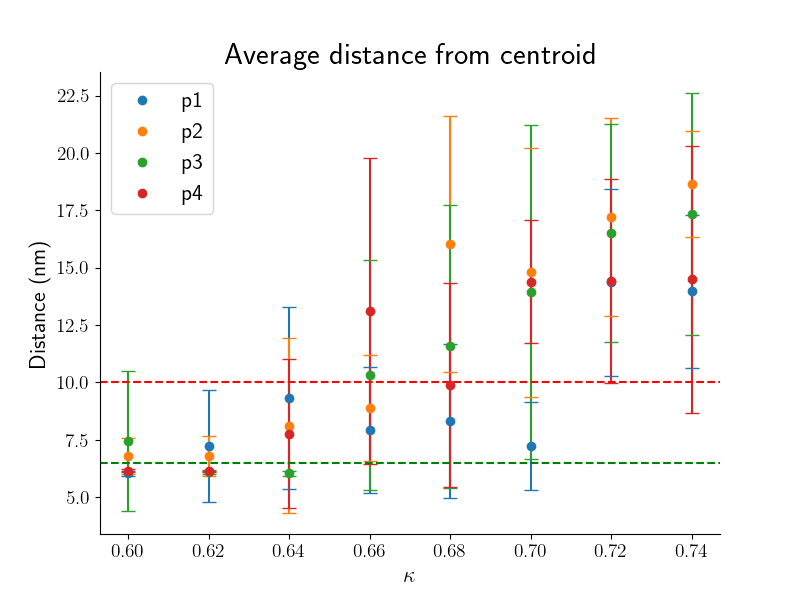

In [435]:
p1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
p2_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_2_id)]
p2_plot.sort_values(by='kappa')
p3_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_3_id)]
p3_plot.sort_values(by='kappa')
p4_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_4_id)]
p4_plot.sort_values(by='kappa')

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(fig, ax, xlabel="$\kappa$", ylabel="Distance (nm)", title="Average distance from centroid")
p.add_plot(x=p1_plot['kappa'], y=p1_plot['avg_distance_mean'], yerr=p1_plot['avg_distance_std'],
           linestyle='None', marker='o', label='p1')
p.add_plot(x=p2_plot['kappa'], y=p2_plot['avg_distance_mean'], yerr=p2_plot['avg_distance_std'],
           linestyle='None', marker='o', label='p2')
p.add_plot(x=p3_plot['kappa'], y=p3_plot['avg_distance_mean'], yerr=p3_plot['avg_distance_std'],
           linestyle='None', marker='o', label='p3')
p.add_plot(x=p4_plot['kappa'], y=p4_plot['avg_distance_mean'], yerr=p4_plot['avg_distance_std'],
           linestyle='None', marker='o', label='p4')
p.disp(False)
ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle='--', label='intact', c='green')
ax.axhline(y = 10, xmin=0, xmax=1, linestyle='--', label='denatured', c='red')
p.fig.savefig("images/Average_all")

<IPython.core.display.Javascript object>


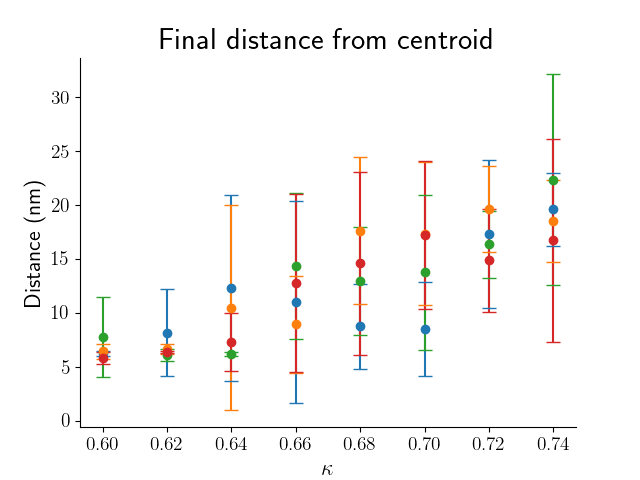

In [302]:
p1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
p2_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_2_id)]
p2_plot.sort_values(by='kappa')
p3_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_3_id)]
p3_plot.sort_values(by='kappa')
p4_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_4_id)]
p4_plot.sort_values(by='kappa')

#fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(xlabel="$\kappa$", ylabel="Distance (nm)", title="Final distance from centroid", ypad=0.7)
p.add_plot(x=p1_plot['kappa'], y=p1_plot['final_distance_mean'], yerr=p1_plot['final_distance_std'],
           linestyle='None', marker='o', label='p1')
p.add_plot(x=p2_plot['kappa'], y=p2_plot['final_distance_mean'], yerr=p2_plot['final_distance_std'],
           linestyle='None', marker='o', label='p2')
p.add_plot(x=p3_plot['kappa'], y=p3_plot['final_distance_mean'], yerr=p3_plot['final_distance_std'],
           linestyle='None', marker='o', label='p3')
p.add_plot(x=p4_plot['kappa'], y=p4_plot['final_distance_mean'], yerr=p4_plot['final_distance_std'],
           linestyle='None', marker='o', label='p4')
p.disp()

<IPython.core.display.Javascript object>


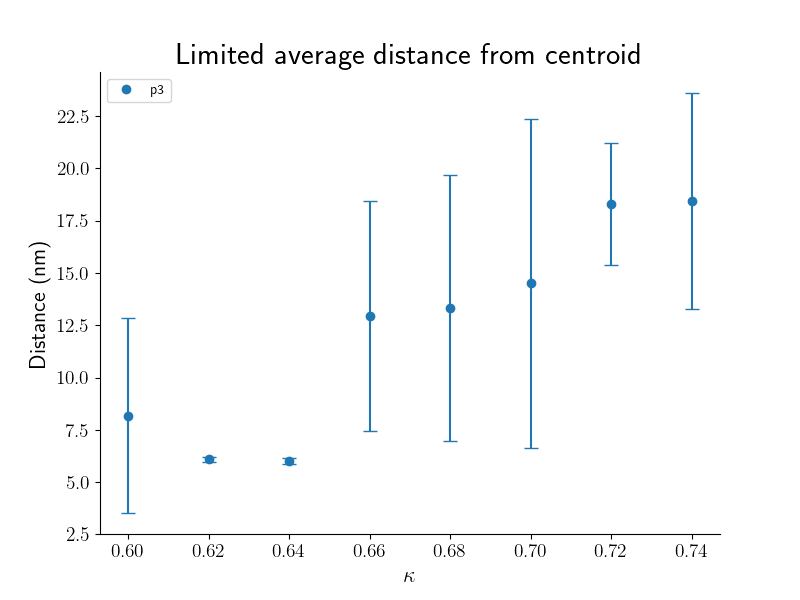

In [304]:
p1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)]
p1_plot.sort_values(by='kappa')
p2_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_2_id)]
p2_plot.sort_values(by='kappa')
p3_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_3_id)]
p3_plot.sort_values(by='kappa')
p4_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_4_id)]
p4_plot.sort_values(by='kappa')

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
p = pretty_error_plot(fig, ax, xlabel="$\kappa$", ylabel="Distance (nm)",
                      title="Limited average distance from centroid")
#p.add_plot(x=p1_plot['kappa'], y=p1_plot['limited_avg_distance_mean'], yerr=p1_plot['limited_avg_distance_std'],
#           linestyle='None', marker='o', label='p1')
#p.add_plot(x=p2_plot['kappa'], y=p2_plot['limited_avg_distance_mean'], yerr=p2_plot['limited_avg_distance_std'],
#           linestyle='None', marker='o', label='p2')
p.add_plot(x=p3_plot['kappa'], y=p3_plot['limited_avg_distance_mean'], yerr=p3_plot['limited_avg_distance_std'],
           linestyle='None', marker='o', label='p3')
#p.add_plot(x=p4_plot['kappa'], y=p4_plot['limited_avg_distance_mean'], yerr=p4_plot['limited_avg_distance_std'],
#           linestyle='None', marker='o', label='p4')
p.disp(False)

In [243]:
df_data_all[np.round(df_data_all['avg_distance']) == 7]

avg_distance                                           distance  \
0        7.475224  [2.287746429, 5.803862572, 6.441311836, 6.4389...   
3        7.271084  [2.276842117, 4.78014946, 5.318775177, 6.43716...   
6        7.243313  [3.018810749, 5.762825966, 6.443487167, 5.5319...   
40       7.487855  [2.287746429, 5.828201294, 6.440355778, 6.4370...   
50       6.868743  [2.283719301, 5.206237793, 6.453302383, 6.4607...   
90       6.807823  [2.288049221, 6.43618679, 5.811220646, 6.00274...   
126      7.192246  [3.0671525, 5.678836346, 6.425261021, 6.424893...   
146      6.693197  [2.289003849, 4.606976032, 6.440089226, 6.4352...   
156      6.763852  [2.276842117, 4.771543503, 5.310201168, 6.4336...   

        error  final_distance                               job  \
0    0.058600        6.392382  a200b61f109f66faa8b542789081eba8   
3    0.117771        6.142323  298191e07a4f9de55b71d598c9cb9553   
6    0.256079        7.504730  ffddec8859e8a747b9864aba5ef11d72   
40   0.040184        6.792953  cfc204e4be69e8a63d8c294559d77914   
50   0.110251        5.014278  d205fa33946cae62f8a09dfed1ab7c57   
90   0.225264        8.264729  f82b6392a3e65dbd3efdd89c778948f4   
126  0.235807        6.298952  b5c23065a3e01d721cc569e769a351f3   
146  0.135492        7.369643  279bf168c206a5d234b2564e58a0d2fc   
156  0.135397        8.690671  0ea573945c3bf56f2588df39974dd006   

                                jobid  kappa  limited_avg_distance  \
0    a200b61f109f66faa8b542789081eba8   0.66              7.526783   
3    298191e07a4f9de55b71d598c9cb9553   0.64              7.782178   
6    ffddec8859e8a747b9864aba5ef11d72   0.70              8.936995   
40   cfc204e4be69e8a63d8c294559d77914   0.64              7.398840   
50   d205fa33946cae62f8a09dfed1ab7c57   0.68              7.171934   
90   f82b6392a3e65dbd3efdd89c778948f4   0.70              9.085652   
126  b5c23065a3e01d721cc569e769a351f3   0.66              9.126038   
146  279bf168c206a5d234b2564e58a0d2fc   0.60              7.516879   
156  0ea573945c3bf56f2588df39974dd006   0.66              7.506810   

     limited_error mutated_chain mutation  positive_segments  run_num  
0         0.049361          None     None                  0        1  
3         0.038028          None     None                  1        5  
6         0.236232          None     None                  2        2  
40        0.056055          None     None                  0        1  
50        0.130624          None     None                  1        1  
90        0.174024          None     None                  0        4  
126       0.257315          None     None                  2        1  
146       0.121248          None     None                  0        2  
156       0.132176          None     None                  1        5

In [286]:
df_data_all[(np.abs(df_data_all['kappa'] - 0.68) < 0.01) & (df_data_all['positive_segments'] == proposed_protomer_1_id)]

avg_distance                                           distance  \
20       6.167259  [3.018815756, 5.776506901, 6.441443443, 5.5314...   
95      13.744634  [2.302016258, 6.434804916, 6.319868088, 6.4326...   
123      6.182980  [2.30523777, 5.659654617, 6.432436466, 6.43240...   
130      6.071753  [2.301191807, 6.164329529, 6.418720245, 5.8717...   
141      9.443386  [3.067626238, 5.581611633, 6.429954529, 6.4285...   

        error  final_distance                               job  \
20   0.013397        6.459354  4f1a29eb3e24a9612710b9ac846e5488   
95   0.637220       14.719335  ae00a9d217071e1d7f1f4005c17fdf04   
123  0.021010        5.425699  0d829a0d0ea64f1b468fc688e992a693   
130  0.011846        6.340115  cefce69aa3cf56b0ad0b3737695681fa   
141  0.663621       10.819841  62059d539e2e00dca06e1e262714dfef   

                                jobid  kappa  limited_avg_distance  \
20   4f1a29eb3e24a9612710b9ac846e5488   0.68              6.187757   
95   ae00a9d217071e1d7f1f4005c17fdf04   0.68             16.518325   
123  0d829a0d0ea64f1b468fc688e992a693   0.68              6.219167   
130  cefce69aa3cf56b0ad0b3737695681fa   0.68              6.054531   
141  62059d539e2e00dca06e1e262714dfef   0.68             11.783546   

     limited_error mutated_chain mutation  positive_segments  run_num  
20        0.031115          None     None                  2        2  
95        0.230367          None     None                  2        4  
123       0.030015          None     None                  2        3  
130       0.028106          None     None                  2        5  
141       0.509042          None     None                  2        1

In [226]:
[print("{}: {}".format(j.get_id(), j.document.get('evaluated'))) for j in df_data_all[(df_data_all['kappa'] == 0.64) & (df_data_all['positive_segments'] == proposed_protomer_1_id)]['job']]
df_data_all[(df_data_all['kappa'] == 0.64) & (df_data_all['positive_segments'] == proposed_protomer_1_id)]

425ca483ecf1f8fe16bbdce18d88d156: None
30638dfe7824aa5dc455236ef0bf73c0: True
f320e83da4050840b309757b75520a4c: True
b12038c37fb135057d4be2e606afc981: None
aaf6f06cf91d1074be006287ced6b11d: True


avg_distance                                           distance  \
65       6.131576  [2.30523777, 5.686938763, 6.432190895, 6.43096...   
89       7.999852  [2.301191807, 6.182724953, 6.415712357, 5.8882...   
111     15.502091  [3.067956448, 5.656301498, 6.424625874, 6.4197...   
124      6.012500  [3.019011974, 5.812073708, 6.441404343, 5.5327...   
151     10.922927  [2.302016258, 6.436701775, 6.358089447, 6.4299...   

        error  final_distance                               job  \
65   0.021876        4.576924  425ca483ecf1f8fe16bbdce18d88d156   
89   0.695506       10.201774  30638dfe7824aa5dc455236ef0bf73c0   
111  1.084760       25.744892  f320e83da4050840b309757b75520a4c   
124  0.015942        5.687312  b12038c37fb135057d4be2e606afc981   
151  0.878640       15.509808  aaf6f06cf91d1074be006287ced6b11d   

                                jobid  kappa  limited_avg_distance  \
65   425ca483ecf1f8fe16bbdce18d88d156   0.64              6.169047   
89   30638dfe7824aa5dc455236ef0bf73c0   0.64             13.843297   
111  f320e83da4050840b309757b75520a4c   0.64             21.254581   
124  b12038c37fb135057d4be2e606afc981   0.64              6.002105   
151  aaf6f06cf91d1074be006287ced6b11d   0.64             15.984013   

     limited_error mutated_chain mutation  positive_segments  run_num  
65        0.039889          None     None                  2        3  
89        0.982705          None     None                  2        5  
111       0.288585          None     None                  2        1  
124       0.028025          None     None                  2        2  
151       1.019999          None     None                  2        4

# Testing

## Mutations
This is the plot data from using mutations, but since that didn't work I'm moving it to testing for now.

<IPython.core.display.Javascript object>


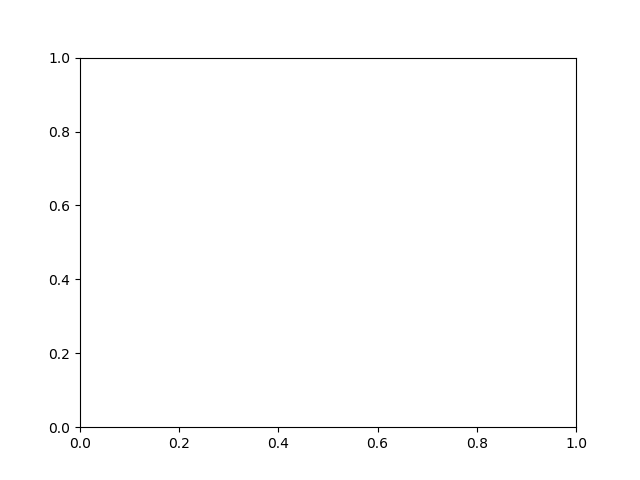

NameError: name 'wt_plot' is not defined

In [34]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt0_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt1_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['final_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['final_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['final_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['final_distance'], label='superfolder')
_ = ax.set_title("Final distance from centroid for proposed protomer 1")
_ = ax.legend()

In [42]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['final_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['final_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['final_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['final_distance'], label='superfolder')
_ = ax.set_title("Final distance from centroid for proposed protomer 1")
_ = ax.legend()

<IPython.core.display.Javascript object>

In [16]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == proposed_protomer_1_id)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['avg_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['avg_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['avg_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['avg_distance'], label='superfolder')
_ = ax.set_title("Average distance from centroid for proposed protomer 1")
_ = ax.legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


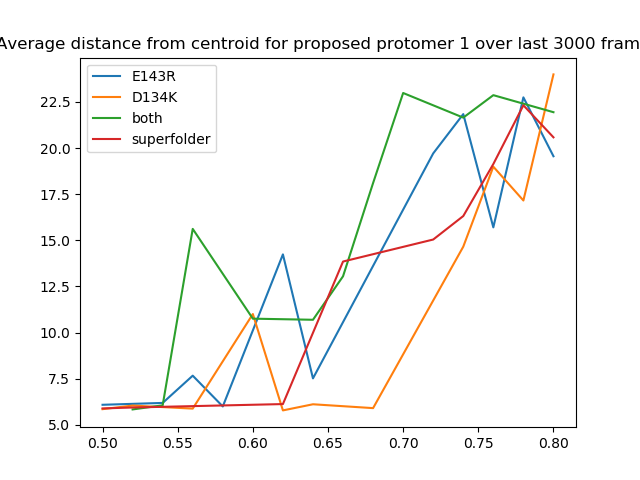

In [19]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == proposed_protomer_4_id)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['limited_avg_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['limited_avg_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['limited_avg_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['limited_avg_distance'], label='superfolder')
_ = ax.set_title("Average distance from centroid for proposed protomer 1 over last 3000 frames")
_ = ax.legend()

<IPython.core.display.Javascript object>


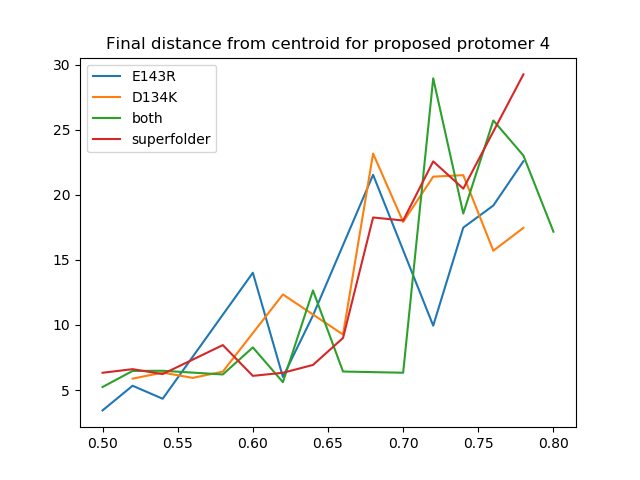

In [21]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['final_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['final_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['final_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['final_distance'], label='superfolder')
_ = ax.set_title("Final distance from centroid for proposed protomer 4")
_ = ax.legend()

<IPython.core.display.Javascript object>


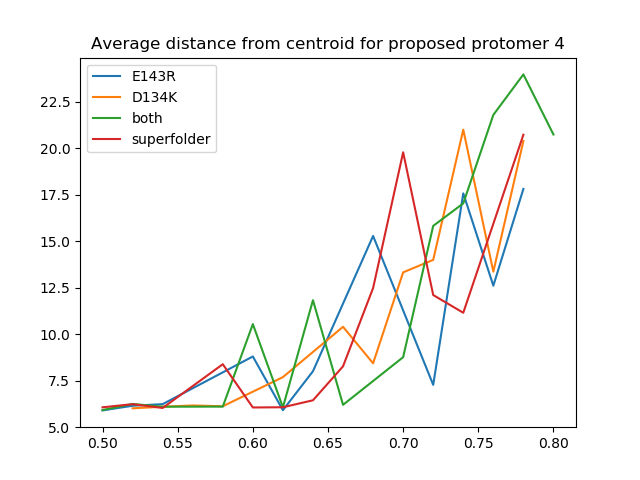

In [24]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['avg_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['avg_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['avg_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['avg_distance'], label='superfolder')
_ = ax.set_title("Average distance from centroid for proposed protomer 4")
_ = ax.legend()

<IPython.core.display.Javascript object>


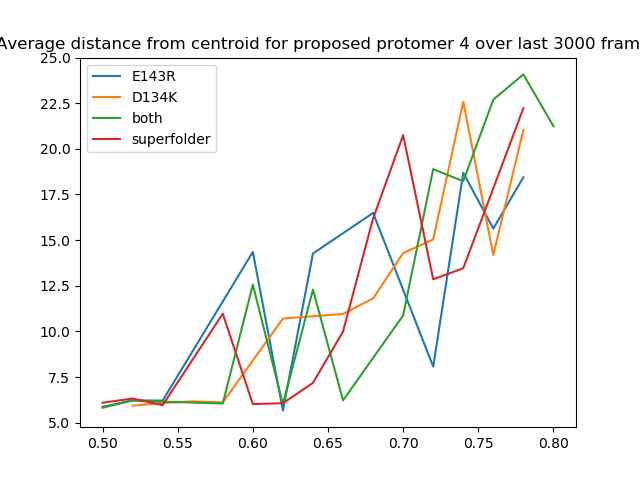

In [25]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['limited_avg_distance'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['limited_avg_distance'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['limited_avg_distance'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['limited_avg_distance'], label='superfolder')
_ = ax.set_title("Average distance from centroid for proposed protomer 4 over last 3000 frames")
_ = ax.legend()

### Plot MSD

<IPython.core.display.Javascript object>


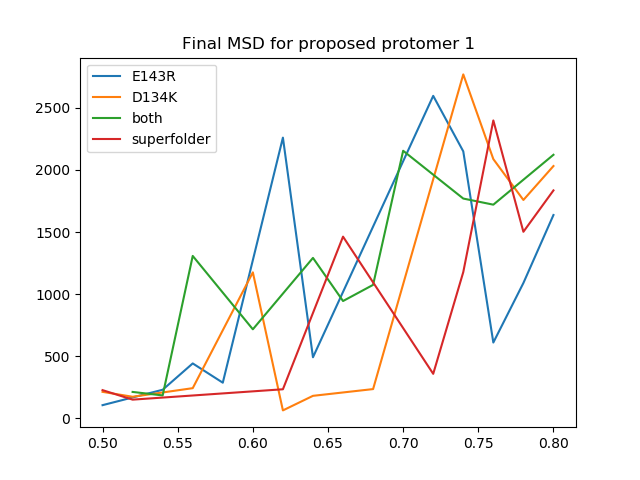

In [38]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['final_msd'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['final_msd'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['final_msd'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['final_msd'], label='superfolder')
_ = ax.set_title("Final MSD for proposed protomer 1")
_ = ax.legend()

<IPython.core.display.Javascript object>


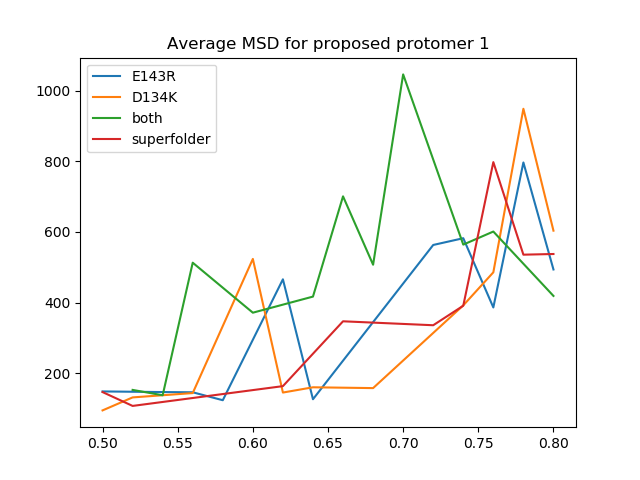

In [39]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['avg_msd'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['avg_msd'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['avg_msd'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['avg_msd'], label='superfolder')
_ = ax.set_title("Average MSD for proposed protomer 1")
_ = ax.legend()

<IPython.core.display.Javascript object>


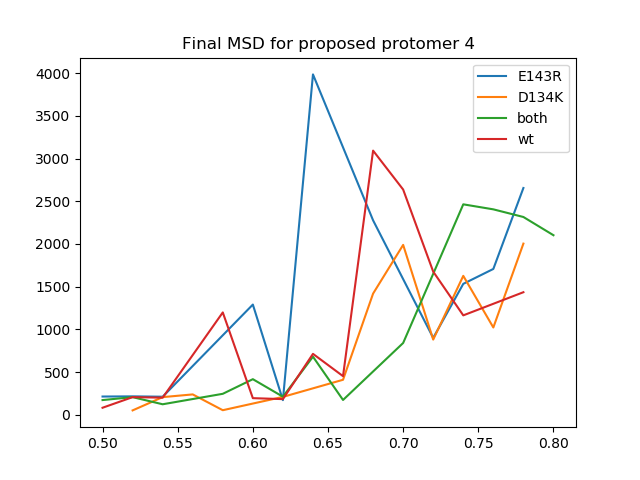

In [40]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['final_msd'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['final_msd'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['final_msd'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['final_msd'], label='wt')
_ = ax.set_title("Final MSD for proposed protomer 4")
_ = ax.legend()

<IPython.core.display.Javascript object>


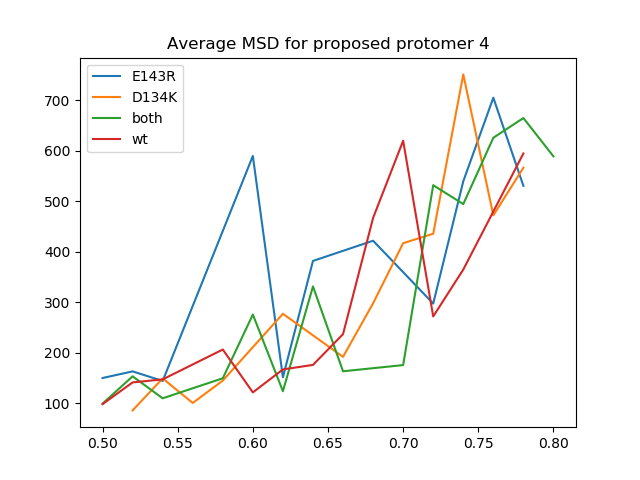

In [41]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['avg_msd'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['avg_msd'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['avg_msd'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['avg_msd'], label='wt')
_ = ax.set_title("Average MSD for proposed protomer 4")
_ = ax.legend()

### Plot traj length

<IPython.core.display.Javascript object>


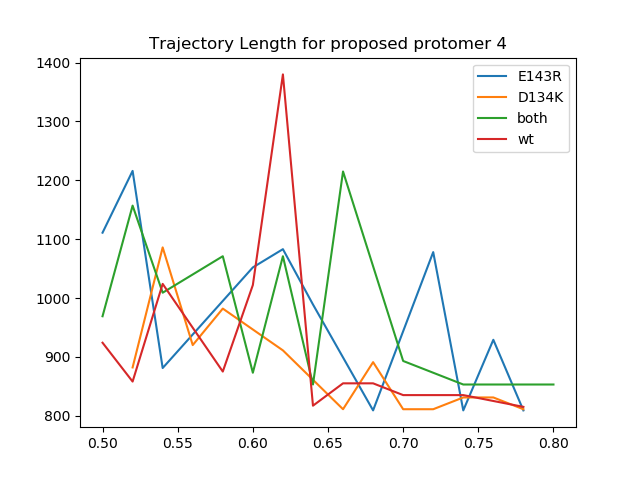

In [105]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 1)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['num_frames'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['num_frames'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['num_frames'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['num_frames'], label='wt')
_ = ax.set_title("Trajectory Length for proposed protomer 4")
_ = ax.legend()

<IPython.core.display.Javascript object>


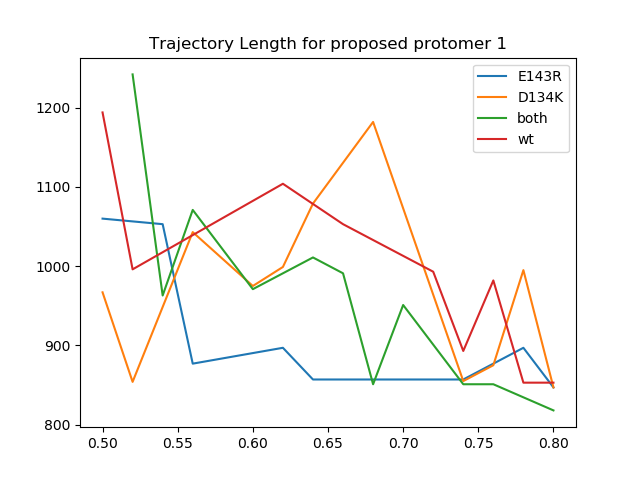

In [106]:
E143R_plot = df_data.loc[(df_data['mutation'] == 'E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
D134K_plot = df_data.loc[(df_data['mutation'] == 'D134K') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
both_plot = df_data.loc[(df_data['mutation'] == 'D134K, E143R') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')
wt_plot = df_data.loc[(df_data['mutation'] == 'None') & (df_data['positive_segments'] == 0)].sort_values(by='kappa')

fig, ax = plt.subplots(1, 1)
_ = ax.plot(E143R_plot['kappa'], E143R_plot['num_frames'], label='E143R')
_ = ax.plot(D134K_plot['kappa'], D134K_plot['num_frames'], label='D134K')
_ = ax.plot(both_plot['kappa'], both_plot['num_frames'], label='both')
_ = ax.plot(wt_plot['kappa'], wt_plot['num_frames'], label='wt')
_ = ax.set_title("Trajectory Length for proposed protomer 1")
_ = ax.legend()

## Distance metric
I'm trying to set up my simulations to automatically terminate when they've deviated enough.
For that, I need a robust way of deciding what is "enough".
I'm just using my actual distance metric, but I'm doing it per frame now.

In [67]:
def frame_centroid_MSD(positions, box):
    """Compute the MSD of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, 0] = np.mod(positions[:, 0]+box.Lx/2, box.Lx)
    positions[:, 1] = np.mod(positions[:, 1]+box.Ly/2, box.Ly)
    positions[:, 2] = np.mod(positions[:, 2]+box.Lz/2, box.Lz)
    positions[:, 0] = np.mod(positions[:, 0]+box.Lx/2, box.Lx)
    positions[:, 1] = np.mod(positions[:, 1]+box.Ly/2, box.Ly)
    positions[:, 2] = np.mod(positions[:, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, 0] = np.where(np.abs(vectors[:, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, 0]),
                                positions[:, 0])
    positions[:, 1] = np.where(np.abs(vectors[:, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, 1]),
                                positions[:, 1])
    positions[:, 2] = np.where(np.abs(vectors[:, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, 2]),
                                positions[:, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 0)
    centroids = centroids[np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    avg_distances = np.mean(distances, axis = -1)
    return avg_distances